# Chat Intents

## UMAP + HDBSCAN

**Summary**

This notebook outlines a way to automatically determine the best hyperparameters for UMAP + HDBSCAN. See the `chatintents_tutorial.ipynb` notebook for a tutorial of the chatintents package, which simplifies and makes it easier to use the methods outlined below.


In [1]:
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

## Load data and pre-trained models

In [2]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [3]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

In [4]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Using /var/folders/_d/glx67tx142z43y0r2thyl3g80000gn/T/tfhub_modules to cache modules.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [5]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('all-distilroberta-v1')

In [6]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [7]:
embeddings_use = embed(model_use, 'use', all_intents)

In [8]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
embeddings = [embeddings_use, embeddings_st1, embeddings_st2, embeddings_st3]

for embedding in embeddings:
    print(embedding.shape)

(1000, 512)
(1000, 768)
(1000, 384)
(1000, 768)


## Helper functions

In [12]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [13]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [14]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search parameter space of clustering pipeline

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               and 'min_cluster_size' and values with
               corresponding lists or ranges of parameters to search
        num_evals: int, number of random parameter combinations to try

    Returns:
        df_result: pandas dataframe containing info on each evaluation
                   performed, including run_id, parameters used, label
                   count, and cost
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     random_state=random_state)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [15]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [16]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [17]:
def combine_results(df_ground, cluster_dict):
    """
    Returns dataframe of all documents and each model's assigned cluster

    Arguments:
        df_ground: dataframe of original documents with associated ground truth
                   labels
        cluster_dict: dict, keys as column name for specific model and value as
                      best clusters HDBSCAN object

    Returns:
        df_combined: dataframe of all documents with labels from
                     best clusters for each model

    """

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [18]:
def summarize_results(results_dict, results_df):
    """
    Returns a table summarizing each model's performance compared to ground
    truth labels and the model's hyperparametes

    Arguments:
        results_dict: dict, key is the model name and value is a list of: 
                      model column name in combine_results output, best_params and best_clusters 
                      for each model (e.g. ['label_use', best_params_use, trials_use])
        results_df: dataframe output of combine_results function; dataframe of all documents 
                    with labels from best clusters for each model

    Returns:
        df_final: dataframe with each row including a model name, calculated ARI and NMI,
                  loss, label count, and hyperparameters of best model

    """
    
    summary = []

    for key, value in results_dict.items():
        ground_label = results_df['category'].values
        predicted_label = results_df[value[0]].values
        
        ari = np.round(adjusted_rand_score(ground_label, predicted_label), 3)
        nmi = np.round(normalized_mutual_info_score(ground_label, predicted_label), 3)
        loss = value[2].best_trial['result']['loss']
        label_count = value[2].best_trial['result']['label_count']
        n_neighbors = value[1]['n_neighbors']
        n_components = value[1]['n_components']
        min_cluster_size = value[1]['min_cluster_size']
        random_state = value[1]['random_state']
        
        summary.append([key, ari, nmi, loss, label_count, n_neighbors, n_components, 
                        min_cluster_size, random_state])

    df_final = pd.DataFrame(summary, columns=['Model', 'ARI', 'NMI', 'loss', 
                                              'label_count', 'n_neighbors',
                                              'n_components', 'min_cluster_size',
                                              'random_state'])
    
    return df_final.sort_values(by='NMI', ascending=False)

In [19]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

## Results with default hyperparameters

In [20]:
clusters_default = generate_clusters(embeddings_st1, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)

In [21]:
labels_def, cost_def = score_clusters(clusters_default)
print(labels_def)
print(cost_def)

32
0.185


Using the default hyperparameter selections from other applications results in a relatively low number of clusters (although still within our specified range of 30 < num_clusters < 100), but nearly 19% of the data is still labeled as noise.

## Tuning hyperparameters

### Random hyperparameter search

In [22]:
%%time

space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use = random_search(embeddings_use, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 6min 7s, sys: 4.63 s, total: 6min 12s
Wall time: 5min 43s


In [23]:
random_use.head(25)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
38,38,12,4,14,2,0.000
35,35,13,5,12,7,0.025
7,7,13,5,13,7,0.025
14,14,13,5,13,7,0.025
89,89,13,5,14,7,0.026
22,22,15,5,12,7,0.029
92,92,14,5,14,7,0.031
81,81,14,3,11,17,0.123
53,53,14,3,11,17,0.123
86,86,15,5,4,59,0.140


### Bayesian optimization with Hyperopt

In [29]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [30]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [05:18<00:00,  3.18s/trial, best loss: 0.086]
best:
{'min_cluster_size': 4, 'n_components': 5, 'n_neighbors': 3, 'random_state': 42}
label count: 79


In [31]:
trials_use.best_trial

{'state': 2,
 'tid': 34,
 'spec': None,
 'result': {'loss': 0.086, 'label_count': 79, 'status': 'ok'},
 'misc': {'tid': 34,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [34],
   'n_components': [34],
   'n_neighbors': [34]},
  'vals': {'min_cluster_size': [2], 'n_components': [2], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 10, 6, 0, 33, 31, 837000),
 'refresh_time': datetime.datetime(2021, 10, 6, 0, 33, 34, 502000)}

In [32]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [06:08<00:00,  3.68s/trial, best loss: 0.056]
best:
{'min_cluster_size': 6, 'n_components': 9, 'n_neighbors': 6, 'random_state': 42}
label count: 55


In [33]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(embeddings_st2, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [05:20<00:00,  3.20s/trial, best loss: 0.075]
best:
{'min_cluster_size': 6, 'n_components': 11, 'n_neighbors': 4, 'random_state': 42}
label count: 56


In [34]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(embeddings_st3, 
                                                                 space=hspace, 
                                                                 label_lower=30, 
                                                                 label_upper=100, 
                                                                 max_evals=100)

100%|██████████| 100/100 [06:12<00:00,  3.73s/trial, best loss: 0.079]            
best:
{'min_cluster_size': 5, 'n_components': 9, 'n_neighbors': 5, 'random_state': 42}
label count: 68


## Evaluate clusters

### Visually inspect clusters

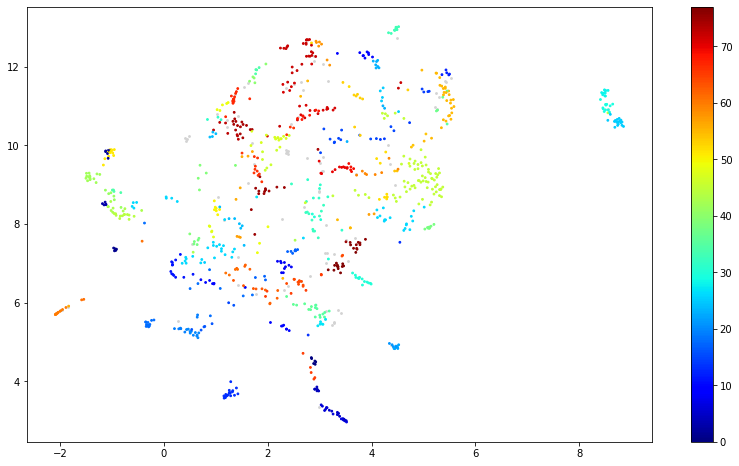

In [35]:
plot_clusters(embeddings_use, best_clusters_use)

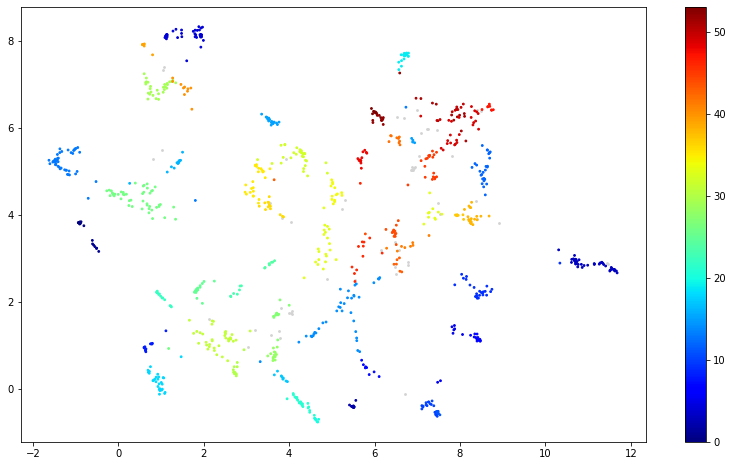

In [36]:
plot_clusters(embeddings_st1, best_clusters_st1)

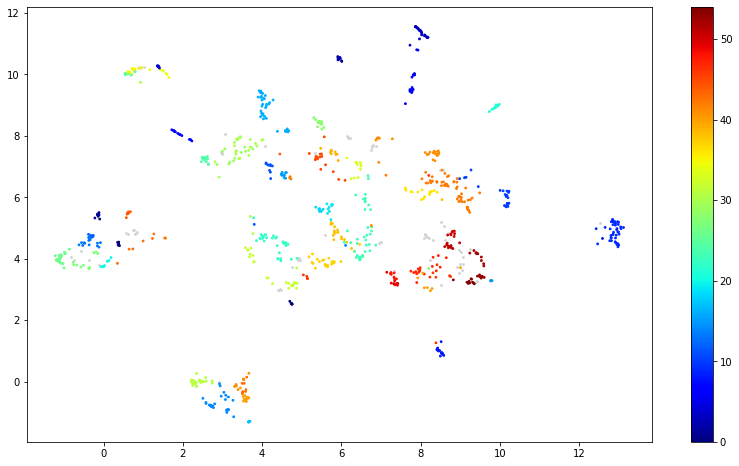

In [37]:
plot_clusters(embeddings_st2, best_clusters_st2)

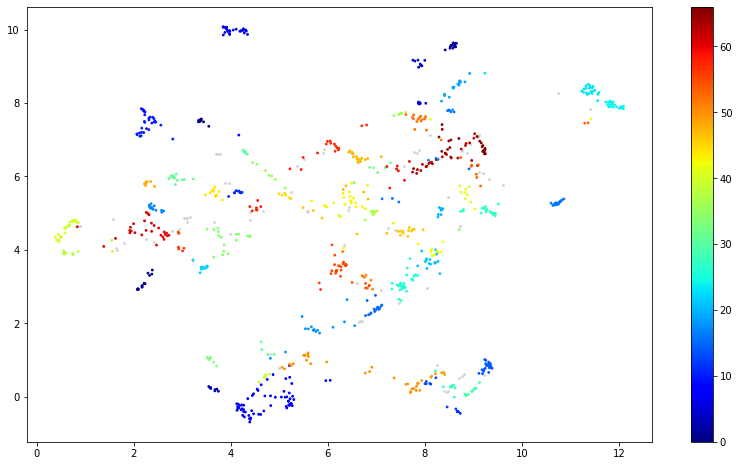

In [38]:
plot_clusters(embeddings_st3, best_clusters_st3)

### Compare clustering performance using ground truth labels

In [39]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st1, 
                'label_st2': best_clusters_st2,
                'label_st3': best_clusters_st3}

results_df = combine_results(data_sample[['text', 'category']], cluster_dict)
    
results_df.head()

,text,category,label_use,label_st1,label_st2,label_st3
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,55,30,15,17
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,67,32,37,-1
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,74,32,37,26
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,71,53,49,27
4,Are there ways for other people to send me money?,receiving_money,26,51,46,-1


In [40]:
model_dict = {'USE': ['label_use', best_params_use, trials_use],
              'all-mpnet-base-v2': ['label_st1', best_params_st1, trials_st1],
              'all-MiniLM-L6-v2': ['label_st2', best_params_st2, trials_st2],
              'all-distilroberta-v1': ['label_st3', best_params_st3, trials_st3]
               }

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
1,all-mpnet-base-v2,0.455,0.806,0.056,55,6,9,6,42
3,all-distilroberta-v1,0.387,0.781,0.079,68,5,9,5,42
2,all-MiniLM-L6-v2,0.404,0.776,0.075,56,4,11,6,42
0,USE,0.248,0.712,0.086,79,3,5,4,42


The ARI and NMI generally, but don't perfectly, follwed the expected trends based on the calculated loss for each model.

### Manually inspect category consistency

In [41]:
results_df[results_df['label_st1']==23]

,text,category,label_use,label_st1,label_st2,label_st3
8,Is there anywhere I can't use my card?,card_acceptance,62,23,29,-1
190,Will my card work at all merchant locations?,card_acceptance,75,23,29,34
278,Where can my card be used?,card_acceptance,62,23,29,34
348,What retailers accept my card?,card_acceptance,-1,23,29,34
422,Is there a list of where I can use my card?,card_acceptance,62,23,29,34
469,What businesses accept this card?,card_acceptance,-1,23,29,34
482,Is there restrictions on where I can use my card?,card_acceptance,62,23,29,34


In [42]:
results_df[results_df['category']=='country_support']

,text,category,label_use,label_st1,label_st2,label_st3
11,Do you do business in the EU?,country_support,61,39,14,12
44,What are the countries you have offices in?,country_support,1,39,17,12
122,Can I use this all over the world?,country_support,43,39,17,12
279,What countries are you available in?,country_support,1,39,17,12
295,What are the countries that you operate in?,country_support,1,39,17,12
311,Can I get a card in the EU?,country_support,61,31,-1,56
503,Which countries do you operate in,country_support,1,39,17,12
600,How do I know which countries you provide service in?,country_support,1,39,17,12
724,"I'm not in the UK, but can I still get a card?",country_support,61,31,29,56
732,Can I get support?,country_support,25,3,-1,23


In [43]:
results_df[results_df['category']=='card_about_to_expire']

,text,category,label_use,label_st1,label_st2,label_st3
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,36,31,30,56
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,36,31,30,56
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,8,31,11,60
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,8,31,11,60
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,8,31,11,60
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,8,31,11,60
551,Where can I have a new bank card sent to China?,card_about_to_expire,36,31,30,-1
584,How do I get a new expiration date?,card_about_to_expire,8,31,11,60
605,Are there any express fees if i want my new card faster?,card_about_to_expire,49,31,11,18
646,My card is almost going to expire.,card_about_to_expire,8,31,11,60


Through manual inspection, it also appears as though sentence-transformer1 performs the best of the models considered.

### Save cluster results

In [44]:
results_df.to_csv('../data/processed/sample_clustered.csv')

## Applying to the full dataset of 10k intents

Demonstrate the same approach as above on the full bank77 dataset. Several of the steps end up taking a bit longer to run on a dataset this size.

In [45]:
data_full = pd.read_csv('../data/raw/train.csv')
data_full.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived after 2 weeks?,card_arrival
2,I have been waiting over a week. Is the card still coming?,card_arrival
3,Can I track my card while it is in the process of delivery?,card_arrival
4,"How do I know if I will get my card, or if it is lost?",card_arrival


In [46]:
all_intents_full = list(data_full['text'])
len(all_intents_full)

10003

In [47]:
embeddings_use_10k = embed(model_use, 'use', all_intents_full)
embeddings_st1_10k = embed(model_st1, 'sentence transformer', all_intents_full)
embeddings_st2_10k = embed(model_st2, 'sentence transformer', all_intents_full)
embeddings_st3_10k = embed(model_st3, 'sentence transformer', all_intents_full)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [48]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [50]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [14:00<00:00,  8.41s/trial, best loss: 0.2641657502749175]
best:
{'min_cluster_size': 14, 'n_components': 8, 'n_neighbors': 3, 'random_state': 42}
label count: 185


The fact that the cost function is still so high for the best model is a helpful indication that we need to modify the ranges used for the hyperparameters.

In [51]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(10,20)),
    "min_cluster_size": hp.choice('min_cluster_size', range(16,36)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [52]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [16:42<00:00, 10.02s/trial, best loss: 0.11906428071578526]
best:
{'min_cluster_size': 34, 'n_components': 15, 'n_neighbors': 4, 'random_state': 42}
label count: 53


In [53]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [17:58<00:00, 10.79s/trial, best loss: 0.07497750674797561]
best:
{'min_cluster_size': 35, 'n_components': 19, 'n_neighbors': 11, 'random_state': 42}
label count: 48


In [54]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(embeddings_st2_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [15:09<00:00,  9.10s/trial, best loss: 0.11056682995101469]
best:
{'min_cluster_size': 32, 'n_components': 18, 'n_neighbors': 8, 'random_state': 42}
label count: 68


In [55]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(embeddings_st3_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [15:21<00:00,  9.22s/trial, best loss: 0.08517444766570029]
best:
{'min_cluster_size': 34, 'n_components': 13, 'n_neighbors': 6, 'random_state': 42}
label count: 69


In [56]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st1, 
                'label_st2': best_clusters_st2,
                'label_st3': best_clusters_st3}

results_df = combine_results(data_full[['text', 'category']], cluster_dict)
    
model_dict = {'USE': ['label_use', best_params_use, trials_use],
              'all-mpnet-base-v2': ['label_st1', best_params_st1, trials_st1],
              'all-MiniLM-L6-v2': ['label_st2', best_params_st2, trials_st2],
              'all-distilroberta-v1': ['label_st3', best_params_st3, trials_st3]
               }

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
3,all-distilroberta-v1,0.407,0.769,0.085174,69,6,13,34,42
1,all-mpnet-base-v2,0.272,0.751,0.074978,48,11,19,35,42
2,all-MiniLM-L6-v2,0.344,0.751,0.110567,68,8,18,32,42
0,USE,0.252,0.673,0.119064,53,4,15,34,42
